# Описание проекта

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Данные находятся в трёх файлах:

gold_recovery_train.csv — обучающая выборка
gold_recovery_test.csv — тестовая выборка 
gold_recovery_full.csv — исходные данные 

Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.
Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.
Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.

В вашем распоряжении сырые данные: их просто выгрузили из хранилища.

# Описание процесса

Как золото получают из руды? Изучите внимательно стадии процесса.
Когда добытая руда проходит первичную обработку, получается дроблёная смесь. Её отправляют на флотацию (обогащение) и двухэтапную очистку.

Опишем каждую стадию:

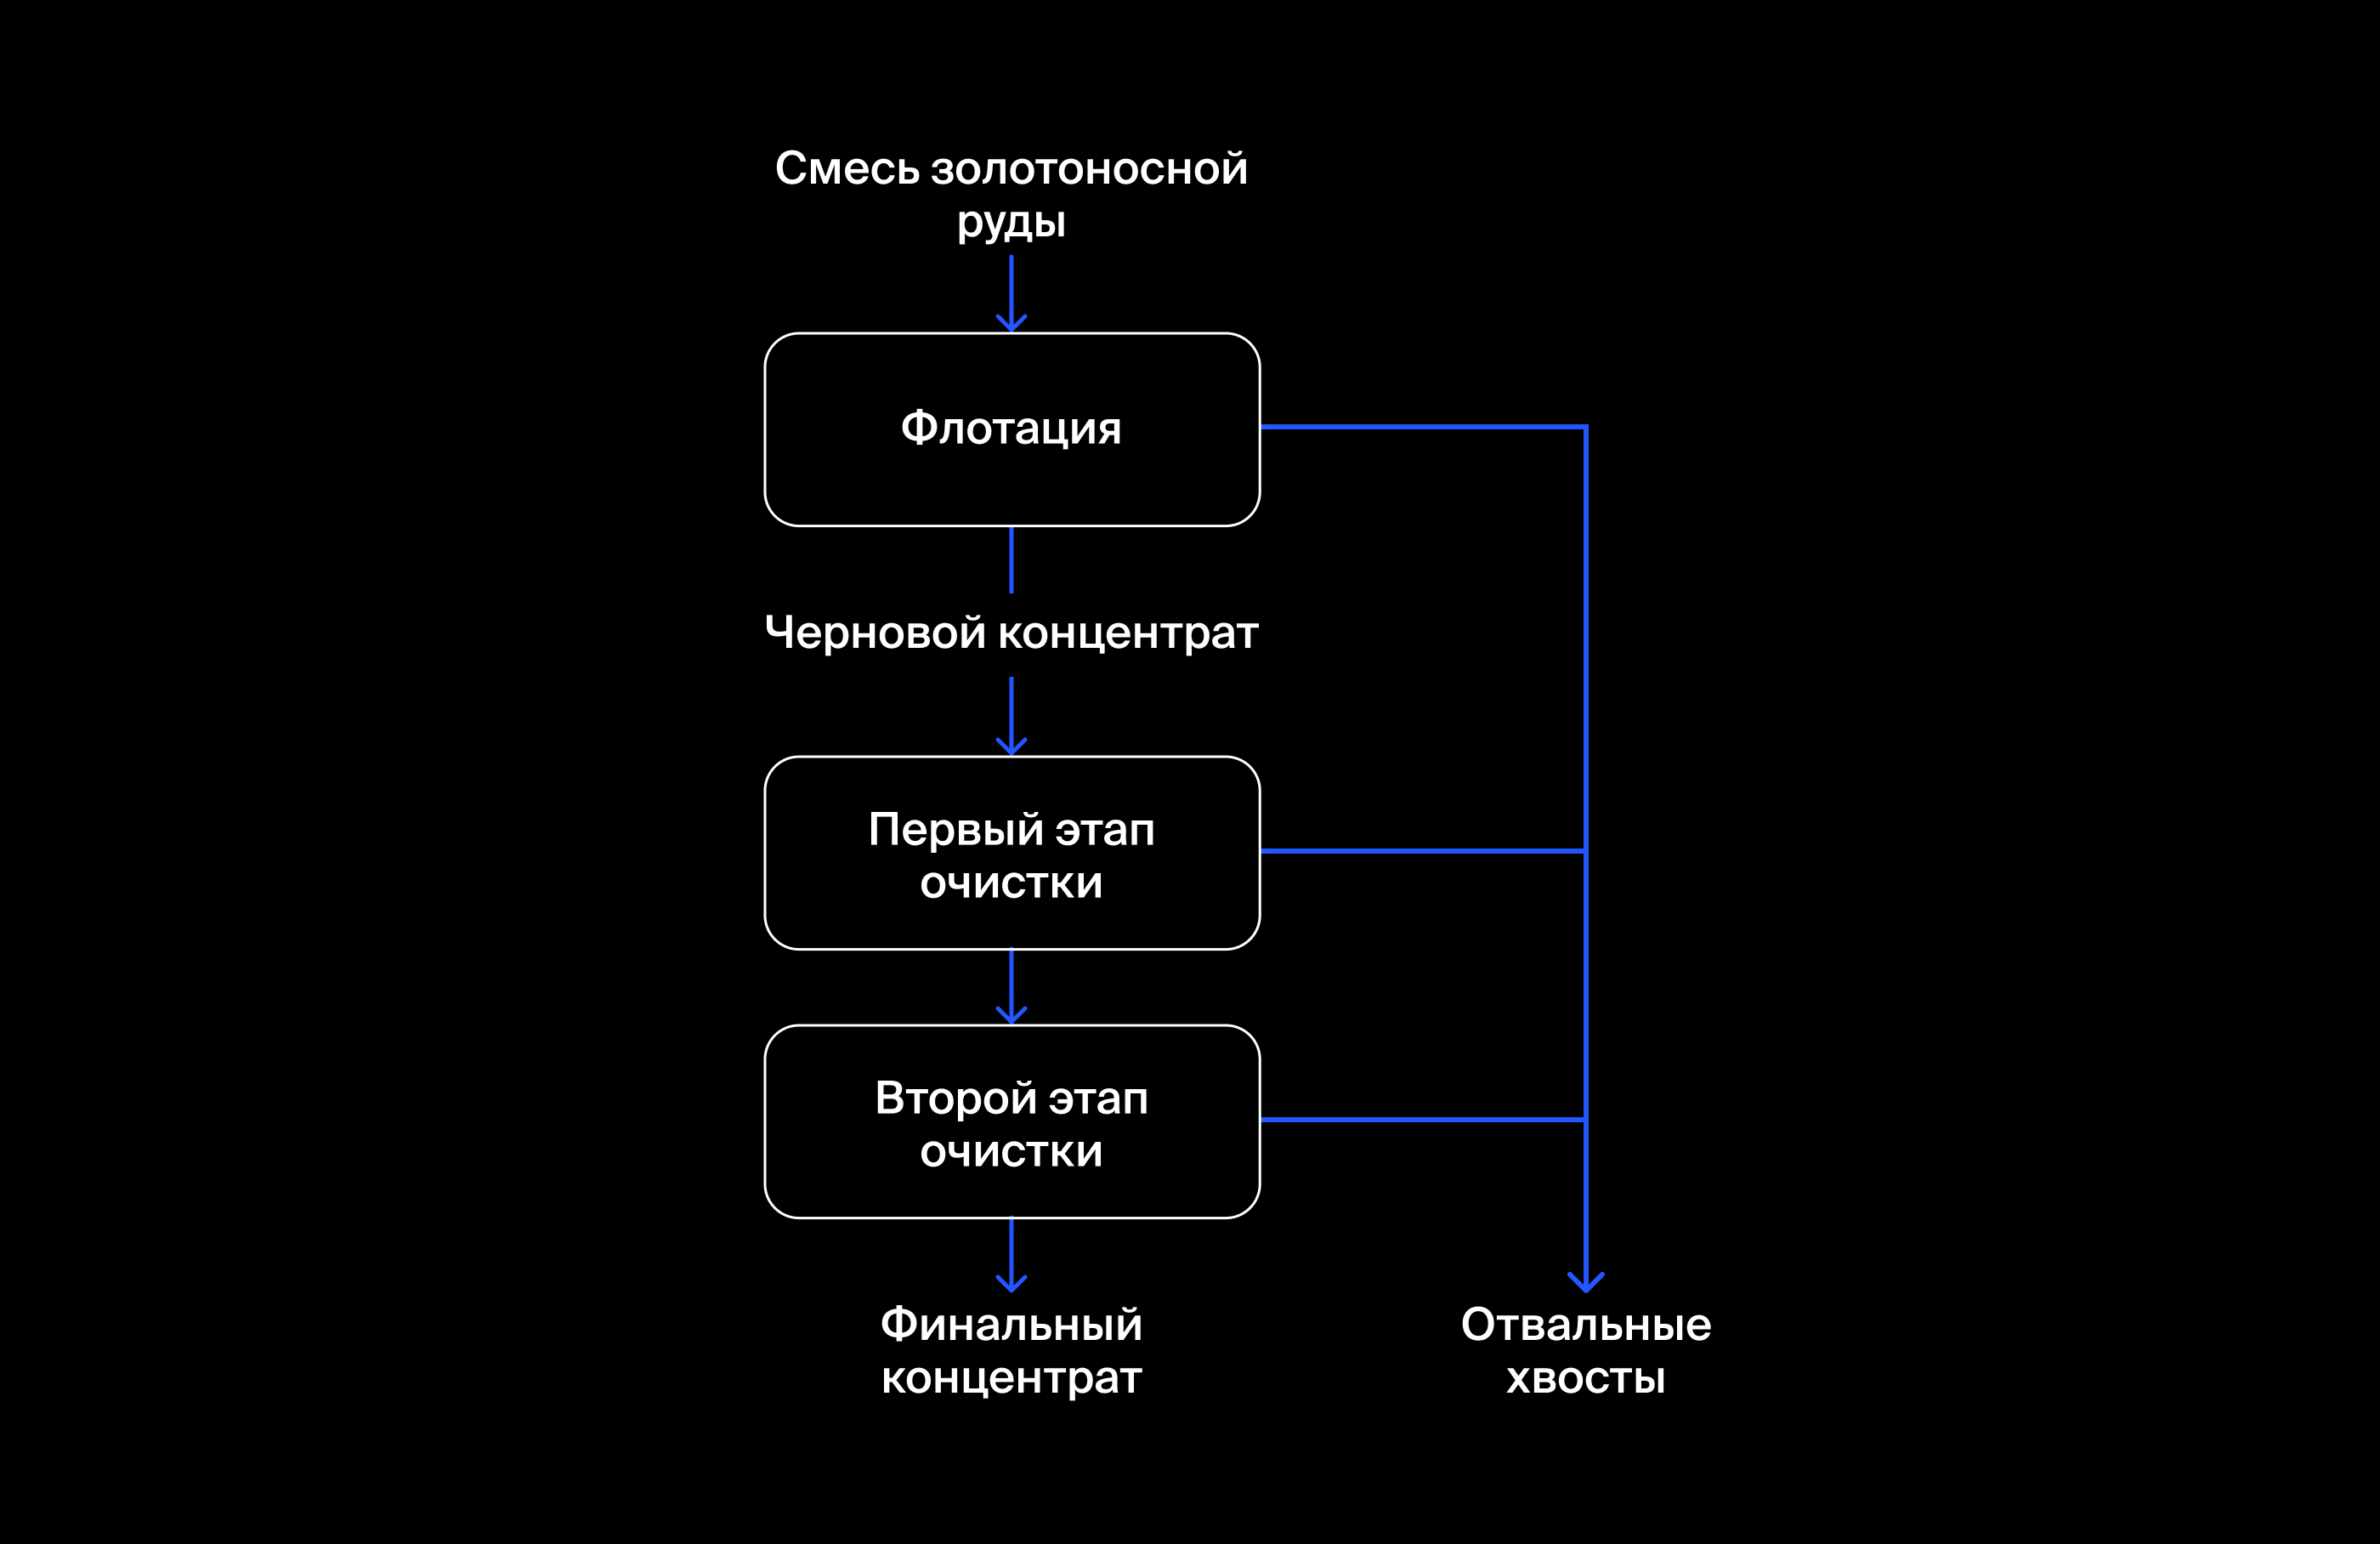

1. Флотация

Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов.
На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости).
2. Очистка

Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.

# Описание данных
## Технологический процесс
* Rougher feed — исходное сырье
* Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
* Xanthate **— ксантогенат (промотер, или активатор флотации);
* Sulphate — сульфат (на данном производстве сульфид натрия);
* Depressant — депрессант (силикат натрия).
* Rougher process (англ. «грубый процесс») — флотация
* Rougher tails — отвальные хвосты
* Float banks — флотационная установка
* Cleaner process — очистка
* Rougher Au — черновой концентрат золота
* Final Au — финальный концентрат золота
## Параметры этапов
* air amount — объём воздуха
* fluid levels — уровень жидкости
* feed size — размер гранул сырья
* feed rate — скорость подачи

## Наименование признаков
Наименование признаков должно быть такое:
[этап].[тип_параметра].[название_параметра]

Пример: rougher.input.feed_ag

Возможные значения для блока [этап]:

* rougher — флотация
* primary_cleaner — первичная очистка
* secondary_cleaner — вторичная очистка
* final — финальные характеристики

Возможные значения для блока [тип_параметра]:
* input — параметры сырья
* output — параметры продукта
* state — параметры, характеризующие текущее состояние этапа
* calculation — расчётные характеристики

# Расчёт эффективности
Вам нужно смоделировать процесс восстановления золота из золотосодержащей руды.

Эффективность обогащения рассчитывается по формуле

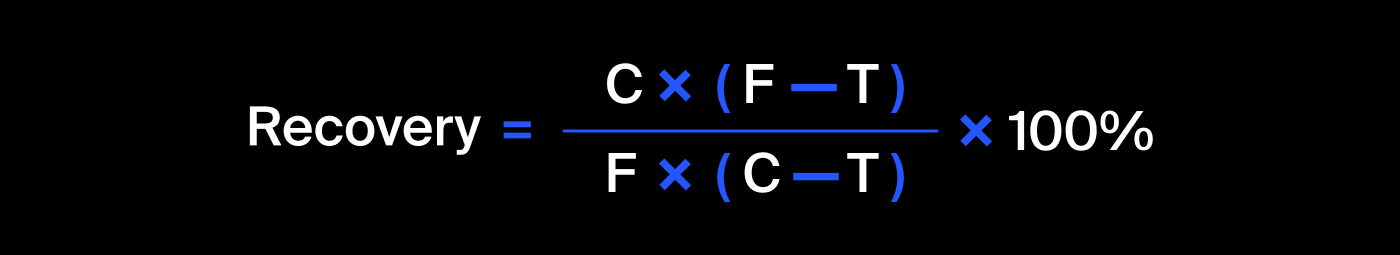

где:

* C — доля золота в концентрате после флотации/очистки;
* F — доля золота в сырье/концентрате до флотации/очистки;
* T — доля золота в отвальных хвостах после флотации/очистки.

Для прогноза коэффициента нужно найти долю золота в концентратах и хвостах. Причём важен не только финальный продукт, но и черновой концентрат.



Метрика sMAPE вычисляется так:

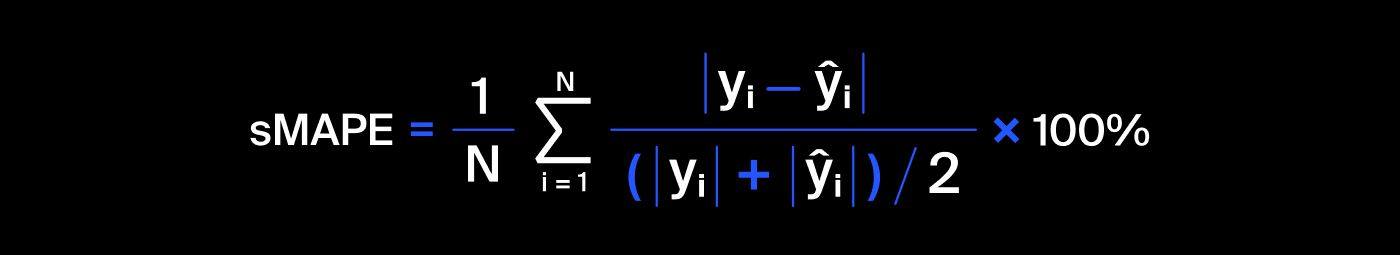



Нужно спрогнозировать сразу две величины:
* эффективность обогащения чернового концентрата rougher.output.recovery;
* эффективность обогащения финального концентрата final.output.recovery.

Итоговая метрика складывается из двух величин:

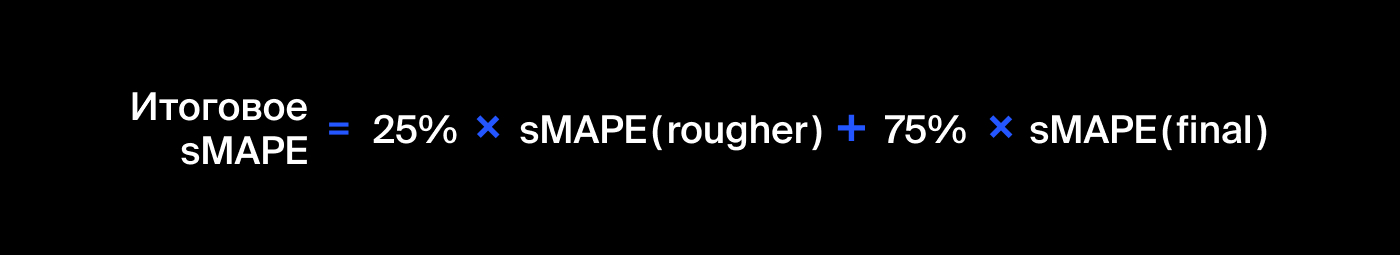

# 1. Подготовка данных

In [1]:
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

train = pd.read_csv(('gold_recovery_train.csv'),index_col='date',parse_dates=['date'])
test = pd.read_csv(('gold_recovery_test.csv'),index_col='date',parse_dates=['date'])
full = pd.read_csv(('gold_recovery_full.csv'),index_col='date',parse_dates=['date'])

In [2]:
train.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [3]:
test.head()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,-500.810606,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [4]:
full.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [5]:
calc = pd.DataFrame()
calc['C'] = train['rougher.output.concentrate_au']
calc['F'] = train['rougher.input.feed_au']
calc['T'] = train['rougher.output.tail_au']

calc= calc.dropna()
calc.info()
calc.query('F == 0')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14610 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 3 columns):
C    14610 non-null float64
F    14610 non-null float64
T    14610 non-null float64
dtypes: float64(3)
memory usage: 456.6 KB


,C,F,T
date,,,
2016-03-02 21:00:00,15.907362,0.0,2.447669
2016-03-02 22:00:00,15.018306,0.0,2.693501
2016-04-15 21:00:00,0.000000,0.0,3.168174
2016-05-01 04:59:59,13.832572,0.0,2.672610
2016-05-20 22:59:59,0.000000,0.0,1.918828
...,...,...,...
2018-01-11 21:59:59,0.000000,0.0,1.900421
2018-01-11 22:59:59,0.000000,0.0,2.311626
2018-01-11 23:59:59,13.491670,0.0,2.362443


Даже после дропа полностью пустых строк у нас остались 63 строки, где отсутствует концентрация золота до флотации но есть после и в хвостах. Раз содержание золота для нашей компании - целевой признак, в реальных условиях я бы задалась вопросом, как такое возможно: это какая-либо ошибка или потеря данных. Но в текущих условях их я также дропну.

In [6]:
calc = calc.query('F > 0')
calc

,C,F,T
date,,,
2016-01-15 00:00:00,19.793808,6.486150,1.170244
2016-01-15 01:00:00,20.050975,6.478583,1.184827
2016-01-15 02:00:00,19.737170,6.362222,1.162562
2016-01-15 03:00:00,19.320810,6.118189,1.079755
2016-01-15 04:00:00,19.216101,5.663707,1.012642
...,...,...,...
2018-08-18 06:59:59,18.603550,5.335862,0.748633
2018-08-18 07:59:59,18.441436,4.838619,0.771582
2018-08-18 08:59:59,15.111231,4.525061,0.685059


In [7]:
#рассчет recovery

def recovery(c, f, t):
    result = ((c * (f - t)) / (f * (c - t))) * 100
    return result

In [8]:
calc['Recovery_calc'] = recovery( calc['C'], calc['F'], calc['T'] )
calc = calc.join(train['rougher.output.recovery']) 
calc.columns = ['C', 'T', 'F', 'Recovery_calc', 'Recovery_target']
calc

,C,T,F,Recovery_calc,Recovery_target
date,,,,,
2016-01-15 00:00:00,19.793808,6.486150,1.170244,87.107763,87.107763
2016-01-15 01:00:00,20.050975,6.478583,1.184827,86.843261,86.843261
2016-01-15 02:00:00,19.737170,6.362222,1.162562,86.842308,86.842308
2016-01-15 03:00:00,19.320810,6.118189,1.079755,87.226430,87.226430
2016-01-15 04:00:00,19.216101,5.663707,1.012642,86.688794,86.688794
...,...,...,...,...,...
2018-08-18 06:59:59,18.603550,5.335862,0.748633,89.574376,89.574376
2018-08-18 07:59:59,18.441436,4.838619,0.771582,87.724007,87.724007
2018-08-18 08:59:59,15.111231,4.525061,0.685059,88.890579,88.890579


In [9]:
calc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14547 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 5 columns):
C                  14547 non-null float64
T                  14547 non-null float64
F                  14547 non-null float64
Recovery_calc      14547 non-null float64
Recovery_target    14287 non-null float64
dtypes: float64(5)
memory usage: 681.9 KB


В исходный значениях recovery всё же есть пропуски. Посмотрим на них:

In [10]:
calc = calc.fillna(0)
calc.query('Recovery_target == 0')

,C,T,F,Recovery_calc,Recovery_target
date,,,,,
2016-01-16 21:00:00,0.000000,7.114065,1.939811,-0.000000,0.0
2016-01-16 22:00:00,0.000000,7.651522,2.087628,-0.000000,0.0
2016-01-16 23:00:00,0.000000,5.587750,2.126460,-0.000000,0.0
2016-01-17 00:00:00,0.000000,4.752992,1.938869,-0.000000,0.0
2016-01-17 01:00:00,0.000000,0.033369,2.043403,0.000000,0.0
...,...,...,...,...,...
2018-08-11 16:59:59,6.038533,11.035269,1.343570,112.957805,0.0
2018-08-11 17:59:59,10.712677,10.943209,1.858404,100.442153,0.0
2018-08-11 18:59:59,0.010000,10.149224,1.729189,-0.482567,0.0


In [11]:
calc.query('Recovery_calc == 0')

,C,T,F,Recovery_calc,Recovery_target
date,,,,,
2016-01-16 21:00:00,0.0,7.114065,1.939811,-0.0,0.0
2016-01-16 22:00:00,0.0,7.651522,2.087628,-0.0,0.0
2016-01-16 23:00:00,0.0,5.587750,2.126460,-0.0,0.0
2016-01-17 00:00:00,0.0,4.752992,1.938869,-0.0,0.0
2016-01-17 01:00:00,0.0,0.033369,2.043403,0.0,0.0
...,...,...,...,...,...
2018-02-11 23:59:59,0.0,7.951063,0.741875,-0.0,0.0
2018-02-12 00:59:59,0.0,8.715784,0.827984,-0.0,0.0
2018-02-12 01:59:59,0.0,9.026122,1.051352,-0.0,0.0


В 260 случаях в исходных значениях recovery_target есть пропуски, но вручную (recovery_calc) мы смогли их посчитать. Однако, для чистоты сравнения МАЕ отбросим строки с нулевыми значениями в обеих recovery, т.е. 580 штук:

In [12]:
calc = calc.query('Recovery_target != 0')

In [13]:
calc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13967 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 5 columns):
C                  13967 non-null float64
T                  13967 non-null float64
F                  13967 non-null float64
Recovery_calc      13967 non-null float64
Recovery_target    13967 non-null float64
dtypes: float64(5)
memory usage: 654.7 KB


In [14]:
print(mean_absolute_error(calc['Recovery_calc'], calc['Recovery_target']))

9.661285240080234e-15


Эффективность обогащения отличается на приблизительно на 9.7*10^(-15) %. Без знания предметной области сложно сказать, является ли это допустимой погрешностью при расчётах или уже стоит беспокоиться, но такое значение присутствует как факт. Значение небольшое, я приму как допустимую погрешность.

In [15]:
train.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16860 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant                      15598 non-null float64
primary_c

In [16]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5856 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.input.feed_ag                    

In [17]:
cols = train.columns.difference(test.columns)
cols

Index(['final.output.concentrate_ag', 'final.output.concentrate_au',
       'final.output.concentrate_pb', 'final.output.concentrate_sol',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_au',
       'final.output.tail_pb', 'final.output.tail_sol',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_au',
       'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol',
       'rougher.calculation.au_pb_ratio',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.output.concentrate_ag', 'rougher.output.concentrate_au',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'roughe

В тестовой выборке отсутствуют данные об итоговой концентрации и хвостах, концентрации и хвостах после первой очистки. 

Ещё есть интересный параметр - rougher.calculation.au_pb_ratio, оценивает отношения содержания золота к свинцу. Дело в том, что даже небольшое количество свинца в золотом сплаве делает его хрупким, непригодном к дальнейшей обработке - свинец не растворяется полностью в золотом сплаве. Видимо, этот показатель сильно влияет на качество золота как сырья для обработки в дальнейшем. Полагаю, что важно, чтобы содержание свинца не превышало какое-то определённое значение.

Следующие столбцы -'rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.calculation.sulfate_to_au_concentrate' - используются для контроля протекания процесса флотации во флотационных установках: контролируется подача сульфата и его концентрация.
Далее идут параметры концентрации металлов и их хвостов после флотации, хвосты после вторичной очистки.

Могу предположить, что из тестовой выборки исключили целевые признаки, наиболее ярко и коротко характеризующие весь процесс, чтобы модель научилась предсказывать результат на основе состояния оборудования, этапа и входных данных о сырье. Также это могут быть расчетные данные, которые по условию задачи не доступны (рассчитываются позже).

Прежде чем предобрабатывать, посмотрим, чего и сколько предстоит предобрабатывать. Подсчитаем количество пропусков и их отношение ко всем значениями столбца:

In [18]:
def nans (data):
    df = pd.DataFrame()
    df['count'] = data.isnull().sum()
    df['%'] = df['count'] / len(data)
    return df.sort_values('%', ascending=False)

nans(train).head(10)

,count,%
rougher.output.recovery,2573,0.152610
rougher.output.tail_ag,2250,0.133452
rougher.output.tail_sol,2249,0.133393
rougher.output.tail_au,2249,0.133393
secondary_cleaner.output.tail_sol,1986,0.117794
rougher.input.floatbank11_xanthate,1904,0.112930
final.output.recovery,1521,0.090214
primary_cleaner.input.sulfate,1307,0.077521
primary_cleaner.input.depressant,1262,0.074852
rougher.calculation.au_pb_ratio,1242,0.073665


In [19]:
nans(test).head(10)

,count,%
rougher.input.floatbank11_xanthate,353,0.060280
primary_cleaner.input.sulfate,302,0.051571
primary_cleaner.input.depressant,284,0.048497
rougher.input.floatbank10_sulfate,257,0.043887
primary_cleaner.input.xanthate,166,0.028347
rougher.input.floatbank10_xanthate,123,0.021004
rougher.input.feed_sol,67,0.011441
rougher.input.floatbank11_sulfate,55,0.009392
rougher.input.feed_rate,40,0.006831
secondary_cleaner.state.floatbank3_a_air,34,0.005806


В тесте пропусков немного, в трейне больше. Подход к предобработке может повлиять на итоговую модель, и я бы хотела вынести предобработку к этупу обучения модели. Ну и чтобы на анализе данных посмотреть на чиcтые данные,без заполнения пропусков.

In [20]:
columns = list(set(train) & set(test))
columns

['rougher.state.floatbank10_c_level',
 'primary_cleaner.state.floatbank8_a_level',
 'rougher.input.floatbank11_xanthate',
 'rougher.state.floatbank10_b_air',
 'secondary_cleaner.state.floatbank5_b_level',
 'rougher.input.floatbank10_xanthate',
 'rougher.input.feed_ag',
 'rougher.input.feed_size',
 'primary_cleaner.state.floatbank8_d_level',
 'secondary_cleaner.state.floatbank3_a_level',
 'rougher.state.floatbank10_a_level',
 'rougher.state.floatbank10_e_level',
 'secondary_cleaner.state.floatbank3_a_air',
 'secondary_cleaner.state.floatbank3_b_air',
 'primary_cleaner.state.floatbank8_d_air',
 'secondary_cleaner.state.floatbank5_a_air',
 'rougher.state.floatbank10_d_level',
 'primary_cleaner.state.floatbank8_c_air',
 'primary_cleaner.state.floatbank8_c_level',
 'rougher.state.floatbank10_b_level',
 'rougher.input.feed_rate',
 'rougher.state.floatbank10_e_air',
 'rougher.input.floatbank10_sulfate',
 'secondary_cleaner.state.floatbank5_a_level',
 'rougher.input.feed_au',
 'primary_cleaner

Оставила одинаковые признаки в обоих датасетах.

# 2. Анализ данных

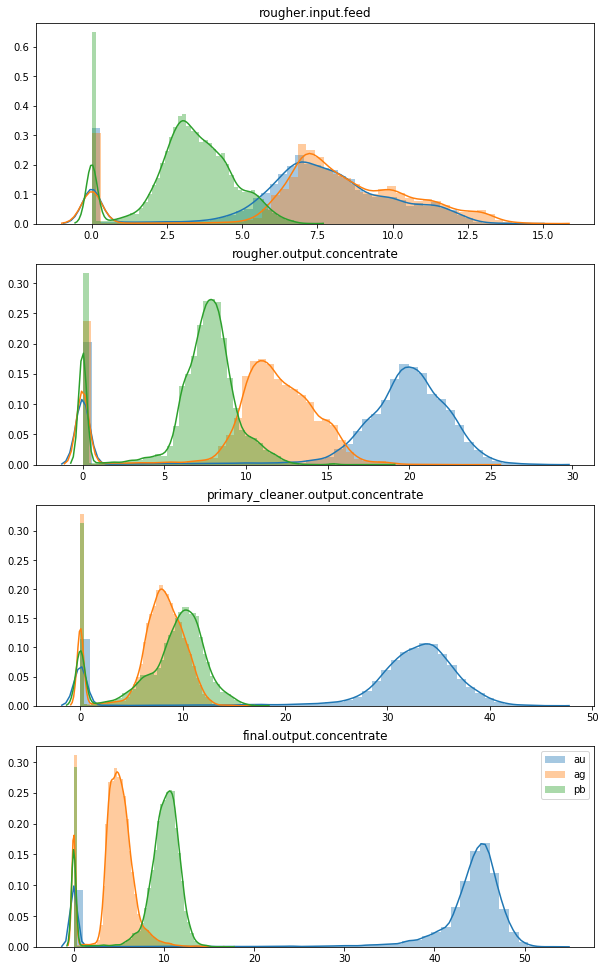

In [21]:
metals = ['au', 'ag', 'pb']

phases_concentrate = ['rougher.input.feed', 'rougher.output.concentrate', 'primary_cleaner.output.concentrate', 'final.output.concentrate']

phases_tail = ['rougher.input.feed', 'rougher.output.tail', 'primary_cleaner.output.tail', 'final.output.tail']

figs, axs = plt.subplots(len(phases_concentrate), figsize=(10, 17))

for i, ax in zip(phases_concentrate, axs):
    ax.set_title(i)
    for metal in metals:  
        clmns = train.columns.str.contains(i+'_'+metal)
        fig = sns.distplot(train.loc[:, clmns].dropna(), label=metal, ax=ax)
plt.legend()        


Концентрация золота растёт, и за счёт увеличения его концентрации уменьшается концентрация серебра и свинца. Сначала концентрация свинца увеличивается, но поле первичной очистки она расти перестаёт. Видимо, достигается тот процент содержания свинца, который не влияет на качество золота. Концентрация серебра достигает своего максимума после флотации, потом идёт на спад. Пики в начале - это пропуски.

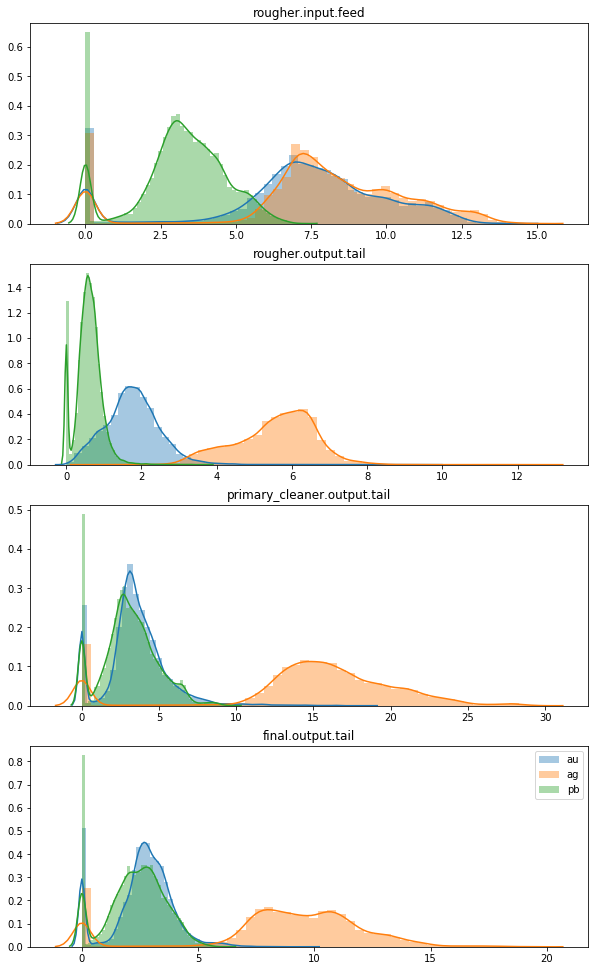

In [22]:
figs, axs = plt.subplots(len(phases_tail), figsize=(10, 17))

for i, ax in zip(phases_tail, axs):
    ax.set_title(i)
    for metal in metals:        
        clmns = train.columns.str.contains(i+'_'+metal)
        fig = sns.distplot(train.loc[:, clmns].dropna(), label=metal, ax=ax)   
plt.legend()


Концентрация в хвостах скачет - после флотации уменьшаентся, после первичной очистки увеличивается, потом снова идёт на спад. Вероятно, это связанно с проходящими реакциями, добавлением реагентов и тд. Так же, как и в концентрации, есть пики на нулях.

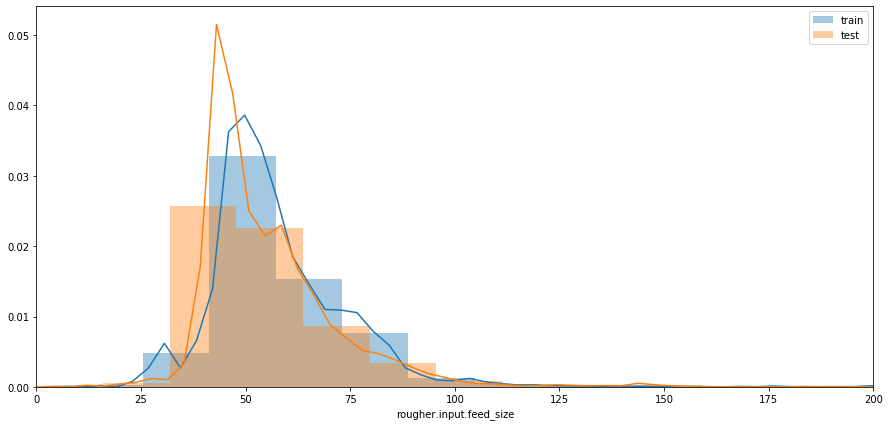

In [23]:
axes =  plt.subplots(figsize= (15 , 7 )) 
z = sns.distplot(train['rougher.input.feed_size'].dropna(),  bins = 30, label='train')
z = sns.distplot(test['rougher.input.feed_size'].dropna(), bins = 30, label='test')
z.set(xlim=(0,200))
plt.legend()


Распределения размеров гранул сырья на обучающей и тестовой выборках похожи, и поэтому оценка модели должна быть верной

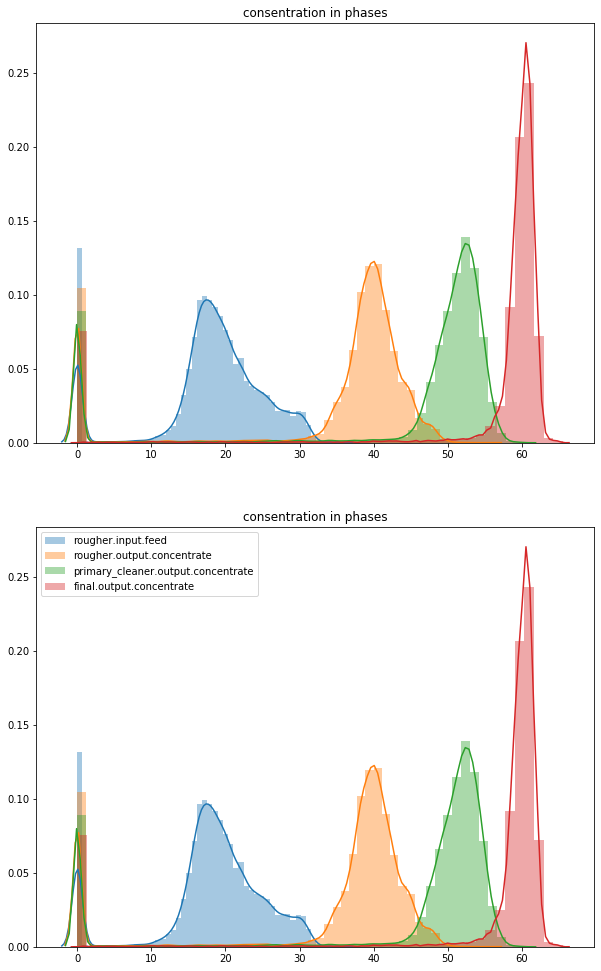

In [24]:
figs, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 17))

for i, ax in zip(phases_concentrate, axs):
    ax.set_title('consentration in phases')
    for phase in phases_concentrate:
        train_cons = train[phase+ '_ag'] + train[phase+ '_au'] + train[phase+ '_pb']
        sns.distplot(train_cons.dropna(),  label=phase, ax=ax)         
plt.legend()

От этапа к этапу концентрация веществ повышается и уменьшается их разброс. Ну и как уже знаем, есть аномалии в виде нулей.

# 3. Модель

In [25]:
def smape(target, prediction):
    x = np.abs(target - prediction)
    y =(np.abs(target)+np.abs(prediction))/2
    fraction = np.divide(x, y)
    result = np.average(fraction, axis=0)
    return result

#функция заполнения пропусков интерполяцией
def fillnan(col): return col.interpolate(method='time')
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16860 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant                      15598 non-null float64
primary_c

In [26]:
train_new = fillnan(train)
test_new = fillnan(test)
train_new = train_new.loc[train_new['rougher.output.recovery'] != 0]
train_new = train_new.loc[train_new['final.output.recovery'] != 0]
train_new = train_new.loc[train_new['final.output.recovery'] < 95]
train_new.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15883 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
final.output.concentrate_ag                           15883 non-null float64
final.output.concentrate_pb                           15883 non-null float64
final.output.concentrate_sol                          15883 non-null float64
final.output.concentrate_au                           15883 non-null float64
final.output.recovery                                 15883 non-null float64
final.output.tail_ag                                  15883 non-null float64
final.output.tail_pb                                  15883 non-null float64
final.output.tail_sol                                 15883 non-null float64
final.output.tail_au                                  15883 non-null float64
primary_cleaner.input.sulfate                         15883 non-null float64
primary_cleaner.input.depressant                      15883 non-null float64
primary_c

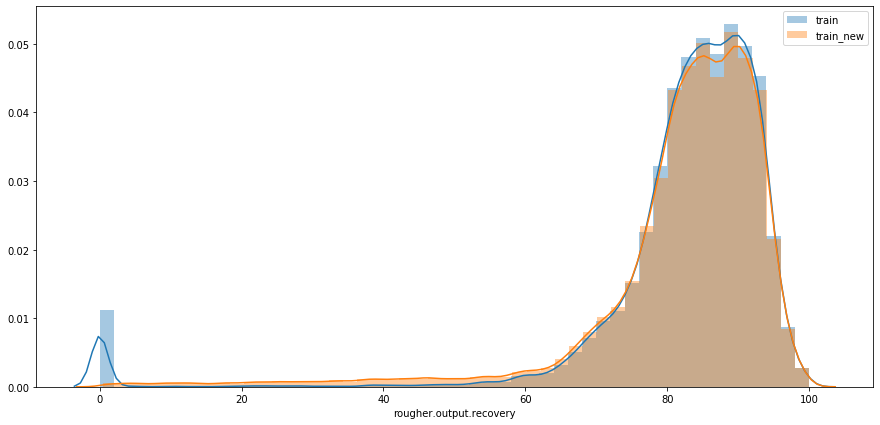

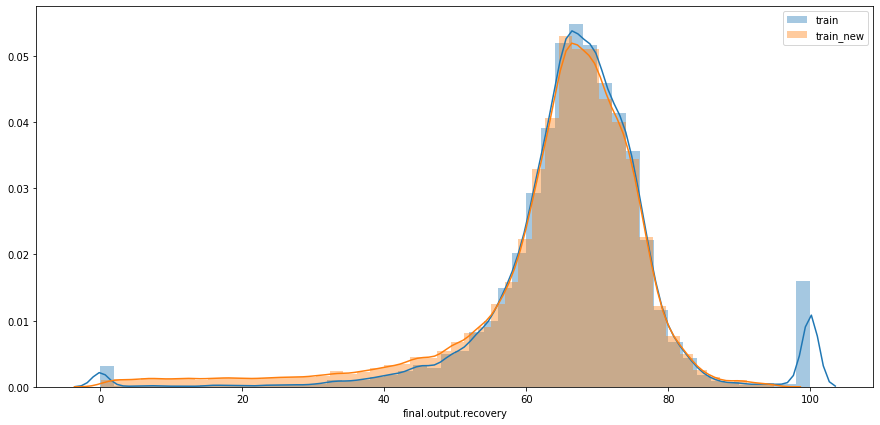

In [27]:
axes =  plt.subplots(figsize= (15 , 7 )) 
sns.distplot(train['rougher.output.recovery'].dropna(), label='train')
sns.distplot(train_new['rougher.output.recovery'], label='train_new')
plt.legend()
plt.show()
axes =  plt.subplots(figsize= (15 , 7 )) 
sns.distplot(train['final.output.recovery'].dropna(), label='train')
sns.distplot(train_new['final.output.recovery'], label='train_new')
plt.legend()
plt.show()

Ушли нули, но в целом форма распределения не изменилась. На втором графике также видно выбросы в районе 95-100, их я тоже посчитала за аномалии и убрала.

In [28]:
train_features = train_new.loc[:,columns]
test_features = test_new.loc[:,columns]
train_target_rougher = train_new.loc[:,['rougher.output.recovery']]
train_features.shape, test_features.shape ,train_target_rougher.shape

((15883, 52), (5856, 52), (15883, 1))

In [29]:
#исследуем дерево
scoring ='r2'
tree_result = pd.DataFrame(columns = ['depth', 'r2'])
i= 0

for depth in range(1, 21, 1):
    model_r_tree = DecisionTreeRegressor(max_depth=depth, random_state=12345)
    scores = cross_val_score(model_r_tree, train_features, train_target_rougher, cv=5, scoring =scoring)
    final_score = sum(scores) / len(scores)
    tree_result.loc[i, 'depth'] = depth
    tree_result.loc[i, 'r2'] = final_score
    i +=1
    
tree_result

,depth,r2
0,1,-0.366859
1,2,-0.38169
2,3,-0.450222
3,4,-0.396008
4,5,-0.632902
5,6,-0.656519
6,7,-0.762584
7,8,-1.49869
8,9,-0.646921
9,10,-1.34292


In [30]:
print('среднее r2 по дереву', tree_result['r2'].mean())

среднее r2 по дереву -1.0324330763693896


In [31]:

#исследуем лес
forest_result = pd.DataFrame(columns = ['estim', 'depth', 'r2'])
i= 0
for estim in range(5, 51, 5):
    for depth in range(2, 11, 2):
        model_r_forest = RandomForestRegressor(n_estimators=estim, max_depth=depth, random_state=12345)
        scores = cross_val_score(model_r_forest, train_features, train_target_rougher, cv=5, scoring =scoring)
        final_score = sum(scores) / len(scores)
        forest_result.loc[i, 'estim'] = estim
        forest_result.loc[i, 'depth'] = depth
        forest_result.loc[i, 'r2'] = final_score
        i +=1
    
forest_result


,estim,depth,r2
0,5,2,-0.371076
1,5,4,-0.342332
2,5,6,-0.388575
3,5,8,-0.693951
4,5,10,-0.682519
5,10,2,-0.354919
6,10,4,-0.338339
7,10,6,-0.336391
8,10,8,-0.434757
9,10,10,-0.435338


In [32]:
print('максимальное r2 по лесу', forest_result['r2'].max())

максимальное r2 по лесу -0.1638428282431133


In [33]:
#исследуем линейную регрессию
model_r_log = LinearRegression()
scores = cross_val_score(model_r_log, train_features, train_target_rougher, cv=5, scoring =scoring)
final_score = sum(scores) / len(scores)

print('Качество линейной регрессии на обучающей выборке:',final_score )

Качество линейной регрессии на обучающей выборке: -0.28533765726068216


Качество дерева хуже всех остальных, поэтому его рассматривать дальше не буду. Кроме того, не знаю, почему так происходит, но при кросс-валидации r2 получается отрицательным(см регрессию и дерево выше). Но посмотрим на r2 без кросс валидации и sMAPE

In [34]:
#рассчитываем r2 для флотации на обеих моделях
from sklearn.metrics import r2_score
model_r_log.fit(train_features, train_target_rougher)
predict_r_log_train = model_r_log.predict(train_features)
predict_r_log_test = model_r_log.predict(test_features)
print("R2 регресии флотация=", r2_score(predict_r_log_train, train_target_rougher))

model_r_forest = RandomForestRegressor(n_estimators=45, max_depth=6, random_state=12345)
model_r_forest.fit(train_features, train_target_rougher)
predict_r_forest_train = model_r_forest.predict(train_features)
predict_r_forest_test = model_r_forest.predict(test_features)
print("R2 леса флотация=", r2_score(predict_r_forest_train, train_target_rougher))

#рассчитываем r2 для финальных характеристик на обеих моделях

train_features_f_log = train_new.loc[:,columns]
train_features_f_log['rougher.output.recovery'] = predict_r_log_train
test_features_f_log = test_new.loc[:,columns]
test_features_f_log['rougher.output.recovery_predict'] = predict_r_log_test

train_features_f_forest = train_new.loc[:,columns]
train_features_f_forest['rougher.output.recovery'] = predict_r_forest_train
test_features_f_forest = test_new.loc[:,columns]
test_features_f_forest['rougher.output.recovery_predict'] = predict_r_forest_test

train_target_final = train_new.loc[:,['final.output.recovery']]

model_f_log = LinearRegression()
model_f_log.fit(train_features_f_log, train_target_final)
predict_f_log_train = model_f_log.predict(train_features_f_log)
predict_f_log_test = model_f_log.predict(test_features_f_log)
print("R2 регресии финал =", r2_score(predict_f_log_train, train_target_final))

model_f_forest = LinearRegression()
model_f_forest.fit(train_features_f_forest, train_target_final)
predict_f_forest_train = model_f_forest.predict(train_features_f_forest)
predict_f_forest_test = model_f_forest.predict(test_features_f_forest)
print("R2 леса финал =", r2_score(predict_f_forest_train, train_target_final))

full = fillnan(full)
test_new = test_new.join(full['rougher.output.recovery'])
rougher_output_recovery_test = test_new['rougher.output.recovery'].values
test_new = test_new.join(full['final.output.recovery'])
final_output_recovery_test = test_new['final.output.recovery'].values

import numpy as np
#считаем sMAPE
smape_r_log = smape(rougher_output_recovery_test,predict_r_log_test)
smape_f_log = smape(final_output_recovery_test,predict_f_log_test)
smape_r_log, smape_f_log
result_smape_log = (0.25*smape_r_log + 0.75*smape_f_log).mean()
print("sMAPE регресии =",result_smape_log)

smape_r_forest = smape(rougher_output_recovery_test,predict_r_forest_test)
smape_f_forest = smape(final_output_recovery_test,predict_f_forest_test)
smape_r_forest, smape_f_forest
result_smape_forest = (0.25*smape_r_forest + 0.75*smape_f_forest).mean()
print("sMAPE леса =",result_smape_forest)

R2 регресии флотация= 0.29408088975957813
R2 леса флотация= 0.6954229481470011
R2 регресии финал = 0.03421507120207423
R2 леса финал = 0.08788918885838459
sMAPE регресии = 0.1895544839069234
sMAPE леса = 0.18101874915356242


Остановимся на модели случайный лес, который даёт нам наименьший sMAPE